In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt

import utils
import multiprocessing as mp
import plotting_utils

In [2]:
from tqdm.notebook import tqdm

In [3]:
def get_NO_count(s):
    # just a SMILES character check
    # other elements that contain N and O in their strings have already been filtered
    return np.sum([s.count(i) for i in "NOno"])

In [4]:
def get_raw_tag(t):
    t1 = t.split("-")[1]
    t2 = t1.split("_")[0]
    
    return t2

In [5]:
e1 = pd.read_csv("./docking_scores/enumeration_0107.csv")
e2 = pd.read_csv("./docking_scores/enumeration_0195.csv")
e3 = pd.read_csv("./docking_scores/enumeration_0387.csv")

In [6]:
e1.columns = ['smiles','tag','score']
e2.columns = ['smiles','tag','score']
e3.columns = ['smiles','tag','score']

In [7]:
a1 = pd.read_csv("docking_scores/amide_scores_0107.csv")
a2 = pd.read_csv("docking_scores/amide_scores_0195.csv")
a3 = pd.read_csv("docking_scores/amide_scores_0387.csv")

In [8]:
a1.columns = ['smiles','tag','score']
a2.columns = ['smiles','tag','score']
a3.columns = ['smiles','tag','score']

In [9]:
# Read reaction distances
dist_dict = {}

for file_tag in tqdm(range(56)):

    file_string = str(file_tag).zfill(2)

    data = pd.read_csv(f"../data_files/smiles_with_all_dists/smiles_with_all_dists_{file_string}.csv")

    data["tag"] = file_tag*1000000 + data.index
    
    for r in data.itertuples():
        dist_dict[r.tag] = r.ac3_am3

  0%|          | 0/56 [00:00<?, ?it/s]

In [10]:
for df in [e1,e2,e3]:
    df["raw_tag"] = df.tag.apply(get_raw_tag)
    df["distance"] = [dist_dict[int(i)] for i in df["raw_tag"]]
    

In [11]:
if __name__ == '__main__':
    with mp.Pool(32) as p:
        n1 = p.map(plotting_utils.check_neutral, a1.smiles,chunksize=10000)
        n2 = p.map(plotting_utils.check_neutral, a2.smiles,chunksize=10000)
        n3 = p.map(plotting_utils.check_neutral, a3.smiles,chunksize=10000)


In [12]:
a1["neutral"] = n1
a2["neutral"] = n2
a3["neutral"] = n3

In [13]:
a1["NO_count"] = a1.smiles.apply(get_NO_count)
a2["NO_count"] = a2.smiles.apply(get_NO_count)
a3["NO_count"] = a3.smiles.apply(get_NO_count)

In [14]:
a1 = a1[(a1.neutral) & (a1.NO_count <= 8)].copy()
a2 = a2[(a2.neutral) & (a2.NO_count <= 8)].copy()
a3 = a3[(a3.neutral) & (a3.NO_count <= 8)].copy()

In [15]:
a1.drop_duplicates(subset="smiles",inplace=True)
a2.drop_duplicates(subset="smiles",inplace=True)
a3.drop_duplicates(subset="smiles",inplace=True)

a1.reset_index(inplace=True,drop=True)
a2.reset_index(inplace=True,drop=True)
a3.reset_index(inplace=True,drop=True)

In [16]:
if __name__ == '__main__':
    with mp.Pool(32) as p:
        n1 = p.map(plotting_utils.getnumatoms, a1.smiles,chunksize=10000)
        n2 = p.map(plotting_utils.getnumatoms, a2.smiles,chunksize=10000)
        n3 = p.map(plotting_utils.getnumatoms, a3.smiles,chunksize=10000)

a1["n_atoms"] = n1
a2["n_atoms"] = n2
a3["n_atoms"] = n3

In [17]:
# plot FC against score for all 3 confs????

In [18]:
conf_dict = {1:"0107",2:"0195",3:"0387"}

In [19]:
def addtoalldata(score_list,datasource,conformer):
    for score in score_list:
        all_data.append([conformer,datasource,score])
    

In [20]:
e1_plot = e1[e1.distance <=6]
e2_plot = e2[e2.distance <=6]
e3_plot = e3[e3.distance <=6]

In [21]:
a1_plot = a1[a1.n_atoms <= 29]
a2_plot = a2[a2.n_atoms <= 29]
a3_plot = a3[a3.n_atoms <= 29]

In [22]:
all_data = []

In [23]:
addtoalldata(e1_plot.score,"enumerated",conf_dict[1])
addtoalldata(e2_plot.score,"enumerated",conf_dict[2])
addtoalldata(e3_plot.score,"enumerated",conf_dict[3])

In [24]:
addtoalldata(a1_plot.score,"amides",conf_dict[1])
addtoalldata(a2_plot.score,"amides",conf_dict[2])
addtoalldata(a3_plot.score,"amides",conf_dict[3])

In [25]:
data = pd.DataFrame(all_data,columns = ["conformer","source","score"])

In [26]:
all_medians = []
for source in ["enumerated", "amides"]:
    for conf in ["0107","0195","0387"]:
        sub_grid = data[(data.source == source) & (data.conformer == conf)]
        median_score = np.median(list(sub_grid.score))
        all_medians.append(median_score)

In [27]:
all_medians

[-11.606873035430908,
 -9.62277126312256,
 -8.429127693,
 -11.382479667663574,
 -8.922090530395508,
 -7.9777116775512695]

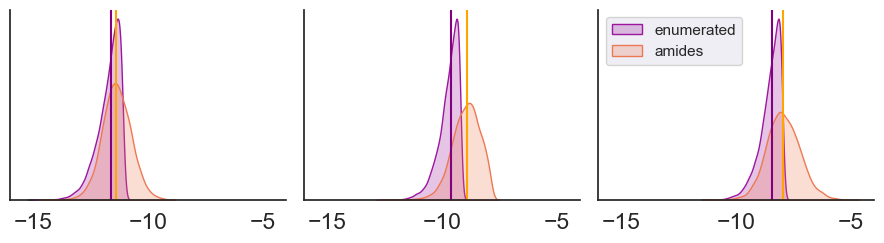

In [28]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
sns.set(rc={'figure.figsize':(10,12)})
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)

g = sns.FacetGrid(data,col="conformer",hue="source",margin_titles=True,sharex=False,sharey=False,palette="plasma")
sns.set(font_scale=1.0)
g.set(yticks=[])
g.map(sns.kdeplot, "score",clip_on=True,fill=True,bw_method=0.2);


x_lims = (-16,-4)
for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes

    ax.axvline(all_medians[i],color="purple")
    ax.axvline(all_medians[i+3],color="orange")
    ax.set_title("")
    ax.set_xticks([-15,-10,-5])
    ax.set_xlabel("")

    ax.set_xlim(x_lims)
plt.subplots_adjust(top=0.9)    
# g.fig.suptitle('Docking scores across conformers',fontsize=15)
plt.savefig(("mPro_with_amide_score_filtered.svg"))
plt.legend()
plt.show()


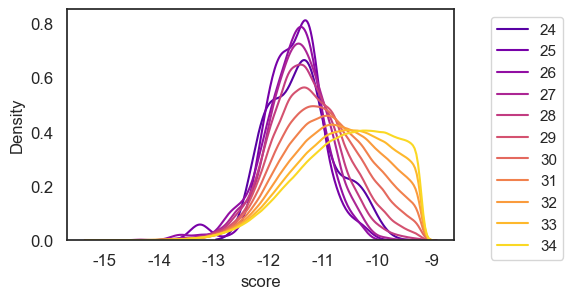

In [29]:
sns.set(style="white", rc={"axes.facecolor": (1, 1, 1, 1)},font_scale=1)
sns.set_palette("plasma",n_colors=12)

plt.figure(figsize=(5,3))
for n_at in range(24,36):
#     print(n_at)
    df_plot = a1[a1.n_atoms <= n_at]
    sns.kdeplot(data=df_plot,x="score",warn_singular=False)
    
ax = plt.gca()
    
ax.set_xticks(range(-15,-8,1))
ax.set_xticklabels(range(-15,-8,1),font="Arial")

ax.set_yticks(np.arange(0,1,0.2))
ax.set_yticklabels(np.round(np.arange(0,1,0.2),2),font="Arial")

plt.legend(labels=[str(i) for i in range(24,36)],bbox_to_anchor=(1.3, 1.0), loc='upper right')

plt.savefig("MPro_0107_scores.svg",format="svg")

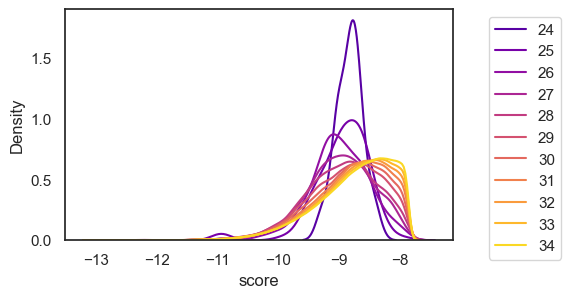

In [30]:
n_atms_list = sorted(list(set(a2.n_atoms)))

sns.set(style="white", rc={"axes.facecolor": (1, 1, 1, 1)},font_scale=1)
sns.set_palette("plasma",n_colors=12)

plt.figure(figsize=(5,3))
for n_at in n_atms_list:
#     print(n_at)
    df_plot = a2[a2.n_atoms <= n_at]
    sns.kdeplot(data=df_plot,x="score",warn_singular=False)
    
ax = plt.gca()
    
x_range = range(-13,-7,1)
y_range = []

# ax.set_xlim([-12,-7])
ax.set_xticks(x_range)
# ax.set_xticklabels(x_range,font="Arial")

# ax.set_yticks(np.arange(0,1,0.2))
# ax.set_yticklabels(np.round(np.arange(0,1,0.2),2),font="Arial")

plt.legend(labels=[str(i) for i in n_atms_list],bbox_to_anchor=(1.3, 1.0), loc='upper right')

plt.savefig("MPro_0195_scores.svg",format="svg")

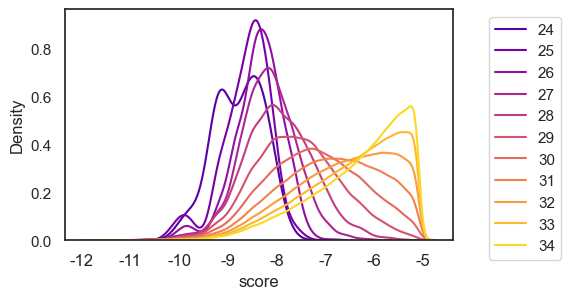

In [31]:
n_atms_list = sorted(list(set(a3.n_atoms)))

sns.set(style="white", rc={"axes.facecolor": (1, 1, 1, 1)},font_scale=1)
sns.set_palette("plasma",n_colors=12)

plt.figure(figsize=(5,3))
for n_at in n_atms_list:
#     print(n_at)
    df_plot = a3[a3.n_atoms <= n_at]
    sns.kdeplot(data=df_plot,x="score",warn_singular=False)
    
ax = plt.gca()
    
x_range = range(-12,-4,1)
y_range = []

# ax.set_xlim([-12,-7])
ax.set_xticks(x_range)
ax.set_xticklabels(x_range,font="Arial")

# ax.set_yticks(np.arange(0,1,0.2))
# ax.set_yticklabels(np.round(np.arange(0,1,0.2),2),font="Arial")

plt.legend(labels=[str(i) for i in n_atms_list],bbox_to_anchor=(1.3, 1.0), loc='upper right')

plt.savefig("MPro_0387_scores.svg",format="svg")